In [215]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
%matplotlib inline

We will use code from `exercise_session14_radioprotection`

<img src=" 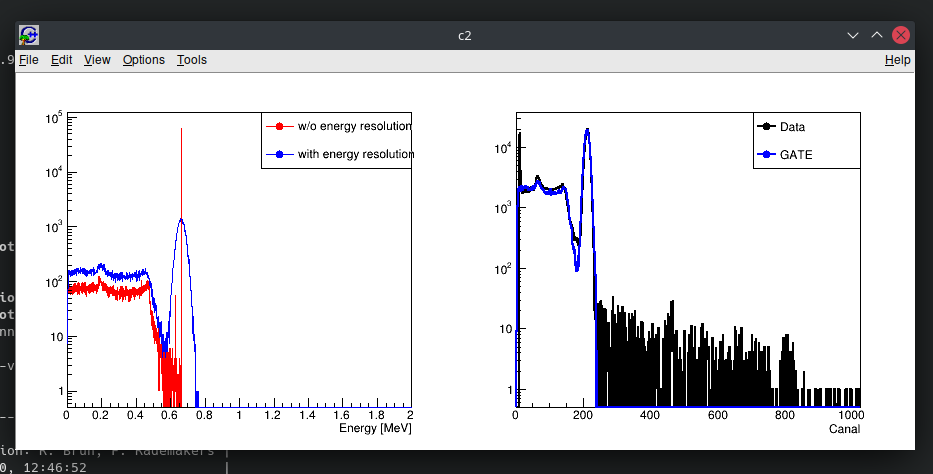" />

In [216]:
ls

 analyse/   output/
 data/     'Reproduce Root analyse.ipynb'
 help/     'Reproduce Root analyse-with-corrections.ipynb'
 mac/


In [217]:
cat analyse/AnalyseRootFile.C

#include <TMath.h>
#include <TH1.h>
#include <TH2.h>
#include <TF1.h>
#include <TF2.h>
#include <TLegend.h>
#include <TROOT.h>
#include <TStyle.h>
#include <TCanvas.h>
#include <TRandom2.h>
#include <TFile.h>

void AnalyseRootFile() 
{	
  
  //NaI detector resolution (experimental)
  Double_t a = -1e-05;
  Double_t b = 0.08;
  Double_t c = 6.;
  TRandom2 *ran       = new TRandom2();

  
  //GATE
  //Get actor results
  TFile *f1 = new TFile("../output/Energy.root","read");
  TH1D *hEdep      = (TH1D *) f1->Get("edepHisto");

  //Create new histograms
  TH1F *hEdepCorr = new TH1F("hEdepCorr","hEdepCorr",2000,0,2);
  TH1D *hEdepCanal = new TH1D("hEdepCanal","hEdepCanal",1024,0,1024);
  TH1D *hCanal = new TH1D("hCanal","hCanal",1024,0,1024);

  //Add detector resolution and convert into canal
  for(int i=1;i < hEdep->GetNbinsX(); i++)
    {
      Double_t nE = hEdep->GetBinContent(i);
      Double_t Edep = i*0.5;

      //Loop on histograms bins
      for(int j = 0;j < nE; j++)
	{
	  
	  

Define some constants

In [218]:
#NaI detector resolution (experimental)
a = -1e-05;
b = 0.08;
c = 6.;

In [219]:
# TFile *f1 = new TFile("../output/Energy.root","read");
f1 = uproot.open("output/Energy.root")

In [220]:
#  TH1D *hEdep      = (TH1D *) f1->Get("edepHisto");
hEdep = f1.get("edepHisto")

What is type of `hEdep` ? 

uproot.dynamic.Model_TH1D_v2

Retrieve data from file into numpy arrays : 

In [209]:
values, bins = hEdep.to_numpy()

In [210]:
values

array([317., 487., 657., ...,   0.,   0.,   0.])

In [211]:
bins

array([0.0000e+00, 5.0000e-04, 1.0000e-03, ..., 1.9990e+00, 1.9995e+00,
       2.0000e+00])

## plot hEdep

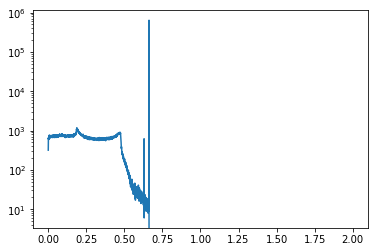

# Reproduce algorithm in `AnalyseRootFile.C`

```c++
    //Add detector resolution and convert into canal
for(int i=1;i < hEdep->GetNbinsX(); i++)
{
  Double_t nE = hEdep->GetBinContent(i);
  Double_t Edep = i*0.5;
  //Loop on histograms bins
  for(int j = 0;j < nE; j++)
    {

      //Add detector resolution
      Double_t sigma_edep = (a*(Edep*Edep)+b*Edep+c)/2.37; //FWHM = 2.37xsigma = axE^2+bxE+c
      Double_t Edepcorr =  ran->Gaus(Edep,sigma_edep) ;

      //Convert into canal
      Double_t Edepcanal = (Edepcorr+12.)/3.18; // calibration linéaire

      //Fill histograms
      if(i>10)
        {
          hEdepCanal->Fill(Edepcanal); 
          hEdepCorr->Fill(Edepcorr/1000.);
        }
    }
}
```

In [221]:
import numpy.random

In [214]:
%%time
hEdepCanalValues = []
hEdepCorrVAlues = []

#code here


CPU times: user 3.32 s, sys: 31.9 ms, total: 3.35 s
Wall time: 3.36 s


Text(0.5, 0, 'Energy [MeV]')

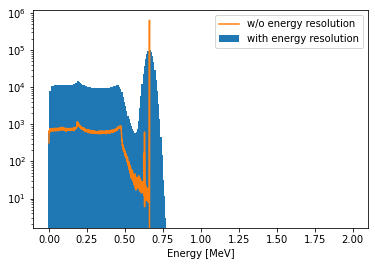

## Optimize it !

In [135]:
values.size

4000

In [138]:
%%time


CPU times: user 65.8 ms, sys: 1.12 ms, total: 67 ms
Wall time: 77.9 ms


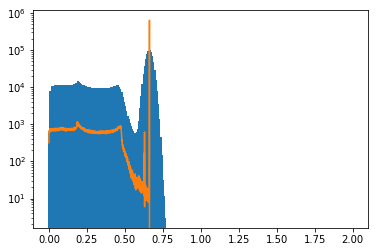

In [139]:
plt.hist(hEdepCorrVAlues, bins=100);
values, bins = hEdep.to_numpy()
plt.plot(bins[:-1], values)
plt.yscale('log')

## Make the second plot

Open expermental data

```c++
 //Genie2000 (experimental measurements)  
  TH1F *hGenie2K = new TH1F("hGenie2K","hGenie2K",1024,0,1024);
  string parametersline;
  std::ifstream fin("137Cs_2cm_5min_bdfsoustr.txt");
  Int_t count = 0.;
  int nbin = 0;
  while(getline(fin,parametersline))
    {
      sscanf(parametersline.c_str(),"%d",&count);
      if(nbin > 10) hGenie2K->Fill(nbin,count);
      nbin+=1;
    }
```

In [142]:
!head analyse/137Cs_2cm_5min_bdfsoustr.txt

In [166]:
%%time
hGenie2KValues = []
hGenie2KBins = []
with open("analyse/137Cs_2cm_5min_bdfsoustr.txt", 'rt') as f:
    for i, line in enumerate(f):               
        if i > 10:
            hGenie2KValues.append(float(line))
            hGenie2KBins.append(float(i))
        

CPU times: user 1.33 ms, sys: 170 µs, total: 1.5 ms
Wall time: 1.13 ms


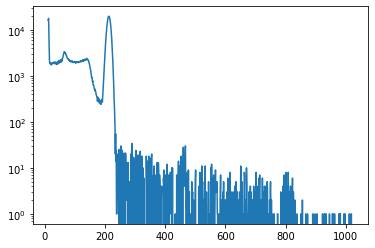

In [167]:
plt.plot(hGenie2KBins, hGenie2KValues)
plt.yscale('log')

In [175]:
hGenie2KValues = np.loadtxt("analyse/137Cs_2cm_5min_bdfsoustr.txt")
hGenie2KBins = np.arange(hGenie2KValues.size)
hGenie2KValues = hGenie2KValues[10:]
hGenie2KBins = hGenie2KBins[10:]

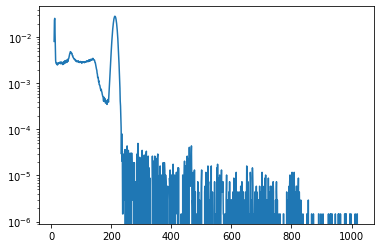

In [186]:
plt.plot(hGenie2KBins, hGenie2KValues / hGenie2KValues.sum())
plt.yscale('log')

```c++
//Normalize to maximum
  hCanal->Scale(hGenie2K->GetMaximum()/hCanal->GetMaximum());
  hEdepCanal->Scale(hGenie2K->GetMaximum()/hEdepCanal->GetMaximum());
```

Text(0.5, 0, 'Canal')

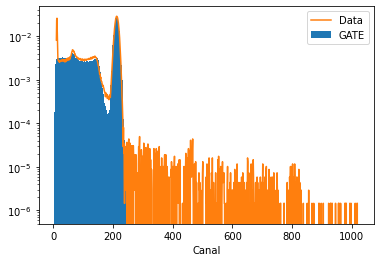

# Final plot

Make the two plots one one figure

Text(0.5, 0, 'Canal')

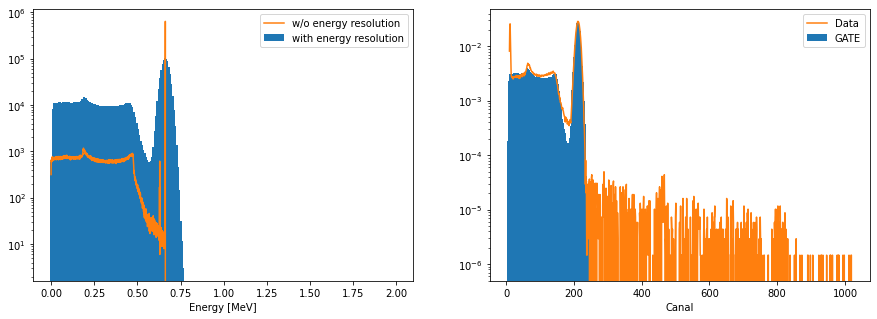

In [206]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
#put code here
plt.subplot(1,2,2)
#put code here